In [1]:
!pip install h5py

In [2]:
!pip install scipy==1.2.1

     |████████████████████████████████| 24.8 MB 1.5 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d fanconic/skin-cancer-malignant-vs-benign

 99% 321M/325M [00:08<00:00, 50.6MB/s]
100% 325M/325M [00:08<00:00, 41.9MB/s]


In [5]:
import os
import zipfile

local_zip = '/content/skin-cancer-malignant-vs-benign.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/skin-cancer-malignant-vs-benign')
zip_ref.close()

In [6]:
import pandas as pd
import numpy as np
from os import listdir
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
from scipy import misc
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, model_from_json
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

In [7]:
train_path=('/content/skin-cancer-malignant-vs-benign/train/')
val_path=('/content/skin-cancer-malignant-vs-benign/test/')
print(listdir(train_path)[:10])
print(listdir(val_path)[:10])
print(listdir(train_path+'/benign')[:10])
print(listdir(val_path+'/malignant')[:10])

['benign', 'malignant']
['benign', 'malignant']
['1027.jpg', '948.jpg', '604.jpg', '1785.jpg', '785.jpg', '496.jpg', '1228.jpg', '1589.jpg', '1031.jpg', '1703.jpg']
['1027.jpg', '948.jpg', '1228.jpg', '342.jpg', '893.jpg', '1187.jpg', '1254.jpg', '817.jpg', '424.jpg', '1007.jpg']


In [8]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tqdm import tqdm
imagesize = 100
def loadBatchImages(path):
    catList = listdir(path)
    loadedImagesTrain = []
    loadedLabelsTrain = []
    for cat in catList:
        if not cat.startswith('.'):
            deepPath = path+cat+"/"
            imageList = listdir(deepPath)
            for images in tqdm(imageList):
                if not images.startswith('.'):
                    img = load_img(deepPath + images)
                    img = misc.imresize(img, (imagesize,imagesize))
                    img = img_to_array(img)
                    loadedLabelsTrain.append(cat)
                    loadedImagesTrain.append(img)   
       
    return loadedImagesTrain, loadedLabelsTrain
loadedImagesTrain, loadedLabelsTrain = loadBatchImages(train_path)

  0%|          | 0/1440 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  from ipykernel import kernelapp as app
100%|██████████| 1197/1197 [00:03<00:00, 366.54it/s]


In [9]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
loadedLabelsTrain = np.asarray(loadedLabelsTrain)
encoder.fit(loadedLabelsTrain)
encoded_loadedLabelsTrain = encoder.transform(loadedLabelsTrain)

In [10]:
del loadedLabelsTrain
import gc
gc.collect()

176

In [11]:
loadedImagesVal, loadedLabelsVal = loadBatchImages(val_path)

  0%|          | 0/360 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
    Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  from ipykernel import kernelapp as app
100%|██████████| 300/300 [00:00<00:00, 386.20it/s]


In [12]:
loadedLabelsVal = np.asarray(loadedLabelsVal)
encoder.fit(loadedLabelsVal)
encoded_loadedLabelsVal = encoder.transform(loadedLabelsVal)

In [13]:
del loadedLabelsVal
import gc
gc.collect()

305

In [14]:
X_train=np.array(loadedImagesTrain)
X_train=X_train/255.0

X_test=np.array(loadedImagesVal)
X_test=X_test/255.0

In [15]:
from keras.utils.np_utils import to_categorical
num_classes = 2
y_trainHot = to_categorical(encoded_loadedLabelsTrain, num_classes = num_classes)
y_testHot = to_categorical(encoded_loadedLabelsVal, num_classes = num_classes)

In [16]:
from sklearn.utils import class_weight

# Convert one hot encoded labels to ints
train_targets_classes = [np.argmax(label) for label in y_trainHot]

# Compute the weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_targets_classes),
                                                  y=train_targets_classes)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 0.915625, 1: 1.1015037593984962}


In [17]:
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [19]:
imageSize =100
pretrained_model_1 = VGG16(include_top=False, input_shape=(imageSize, imageSize, 3))
base_model = pretrained_model_1 # Topless
num_classes = 2
optimizer1 = Adam()
# Add top layer
x = base_model.output
x = Conv2D(80, kernel_size = (3,3), padding = 'valid')(x)
x = Flatten()(x)
x = Dropout(0.75)(x)
predictions = Dense(num_classes, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# Train top layer
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='binary_crossentropy', 
                  optimizer=optimizer1, 
                  metrics=['accuracy'])
model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                              

In [20]:
def create_model_check_point_callback(checkpoint_path,monitor='val_loss'):
    """
    Takes the path where to save the best model weights obtained during training.
    """
    model_checkpoint_cb=tf.keras.callbacks.ModelCheckpoint(
        
        monitor=monitor,
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        save_freq='epoch',
        verbose=1
    )
    return model_checkpoint_cb

In [21]:
ModelCheckPoint_model_cb=create_model_check_point_callback('ModelCheckPoints/model.ckpt')
scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8, verbose=1)

early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)
history = model.fit(X_train,y_trainHot, 
                        epochs=30, 
                        batch_size = 32,
                        validation_data=(X_test,y_testHot), 
                        class_weight= class_weights_dict,
                        verbose=1,callbacks = [ModelCheckPoint_model_cb,scheduler,early_stopper])

plt.show()

Epoch 1/30
83/83 [==============================] - ETA: 0s - loss: 0.6213 - accuracy: 0.7471
Epoch 1: val_loss improved from inf to 0.42258, saving model to ModelCheckPoints/model.ckpt
83/83 [==============================] - 22s 125ms/step - loss: 0.6213 - accuracy: 0.7471 - val_loss: 0.4226 - val_accuracy: 0.8030 - lr: 0.0010
Epoch 2/30
82/83 [============================>.] - ETA: 0s - loss: 0.5035 - accuracy: 0.8007
Epoch 2: val_loss did not improve from 0.42258
83/83 [==============================] - 8s 100ms/step - loss: 0.5029 - accuracy: 0.8009 - val_loss: 0.4308 - val_accuracy: 0.8227 - lr: 0.0010
Epoch 3/30
82/83 [============================>.] - ETA: 0s - loss: 0.4453 - accuracy: 0.8171
Epoch 3: val_loss improved from 0.42258 to 0.41255, saving model to ModelCheckPoints/model.ckpt
83/83 [==============================] - 8s 103ms/step - loss: 0.4471 - accuracy: 0.8161 - val_loss: 0.4125 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 4/30
82/83 [============================>.] 

In [22]:
model_test_result=model.evaluate(X_test,y_testHot)
model_test_result

21/21 [==============================] - 2s 84ms/step - loss: 0.3783 - accuracy: 0.8333


[0.3782716989517212, 0.8333333134651184]

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


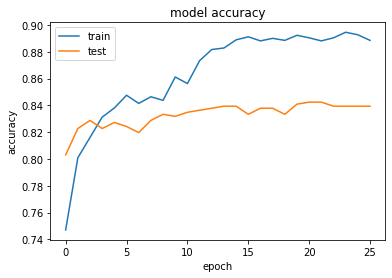

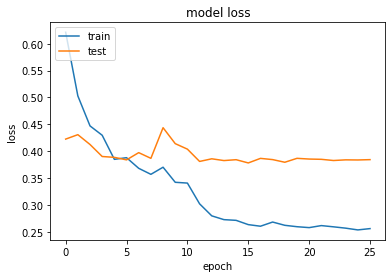

In [23]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

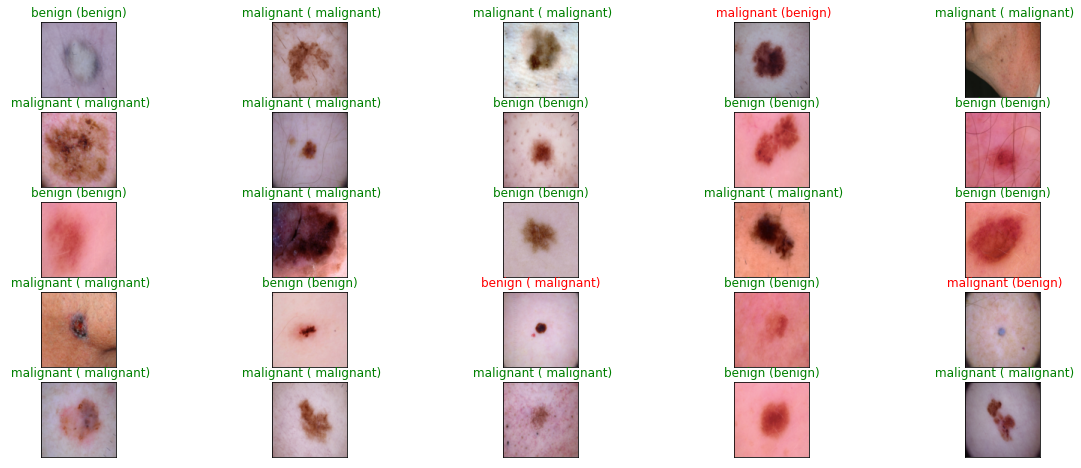

In [24]:
#@title Default title text
labelsFaces =['benign',' malignant' ]


predictedExpression = model.predict(X_test)

figure = plt.figure(figsize=(20, 8))

for i, index in enumerate(np.random.choice(X_test.shape[0], size=25, replace=False)):
    ax = figure.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(predictedExpression[index])
    true_index = np.argmax(y_testHot[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(labelsFaces[predict_index], 
                                  labelsFaces[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()

In [27]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
target_names=['benign','malignant']
label_names=[1,0]
Y_pred=model.predict(X_test)
y_pred=np.argmax(Y_pred,axis=1)
_test=[
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
        ]
cm=confusion_matrix(_test,y_pred,labels=label_names)
print('accuracy')
print(accuracy_score(_test,y_pred))
print("classification_report")
print(classification_report(_test,y_pred,target_names=target_names))


accuracy
0.8333333333333334
classification_report
              precision    recall  f1-score   support

      benign       0.86      0.84      0.85       360
   malignant       0.81      0.83      0.82       300

    accuracy                           0.83       660
   macro avg       0.83      0.83      0.83       660
weighted avg       0.83      0.83      0.83       660



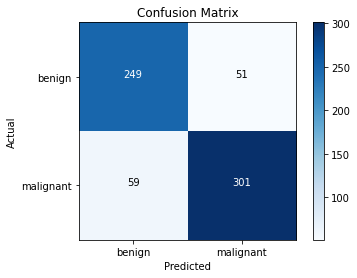

In [28]:
plt.imshow(cm,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
tick_marks = np.arange(len(set(_test))) # length of classes
class_labels = ['benign','malignant']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cm.max() / 2.
for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],'d'),horizontalalignment='center',color='white' if cm[i,j] >thresh else 'black')
plt.show();

In [30]:
model.save("model_benimalig.h5")
from keras.models import load_model
model=load_model('model_benimalig.h5')

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [32]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [33]:
from keras.preprocessing import image

In [38]:
imagePath=('/content/malignant--.jpg')
test_image = image.load_img(imagePath, target_size = (100, 100)) 
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)

In [39]:
if result[0][0] ==1:
  print("it's benign")
else:
    print('malignant')

malignant
